In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, sys, pdb

import gym, eplus_env

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data

from episodic_model import EpisodicModel

sys.path.append('../')

from PPOLearner import PPOLearner
from PPOAgent import PPOAgent
from ReplayMemory import Replay_Memory

# Setup relevant variables

#### Seed

In [3]:
SEED = 42
torch.manual_seed(SEED)

#### Create directory for saving results

In [4]:
results_dir = 'online'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

#### Set Names of relevant variables

In [5]:
obs_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Htg SP", "Clg SP", "Indoor Temp.", "Indoor Temp. Setpoint", "PPD", "Occupancy Flag", "Coil Power", "HVAC Power", "Sys In Temp.", "Sys In Mdot", "OA Temp.", "OA Mdot", "MA Temp.", "MA Mdot", "Sys Out Temp.", "Sys Out Mdot"]

# Modify here: Change based on the specific control problem
state_name = ["Indoor Temp."]
dist_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# Caveat: The RL agent controls the difference between Supply Air Temp. and Mixed Air Temp., i.e. the amount of heating from the heating coil. But, the E+ expects Supply Air Temp. Setpoint.
ctrl_name = ["SA Temp Setpoint"]
target_name = ["Indoor Temp. Setpoint"]

#### Set Hyperparameters

In [6]:
n_state = len(state_name)
n_ctrl = len(ctrl_name)

eta = [0.1, 4] # eta: Weight for comfort during unoccupied and occupied mode
step = 300 * 3 # step: Timestep; Unit in seconds
T = 12 # T: Number of timesteps in the planning horizon
tol_eps = 90 # tol_eps: Total number of episodes; Each episode is a natural day

u_upper = 5
u_lower = 0

perf = []
multiplier = 10 # Normalize the reward for better training performance
n_step = 96     # timesteps per day

# params for training loop
gamma = 0.98
update_episode = 1

#### Load Data

In [7]:
# Read Information on Weather, Occupancy, and Target Setpoint
obs = pd.read_pickle("simulation_results/Dist-TMY3.pkl") # TODO - their example uses TMY3
target = obs[target_name]
disturbance = obs[dist_name]

# Min-Max Normalization
disturbance = (disturbance - disturbance.min())/(disturbance.max() - disturbance.min())

# Train RL Agent

Everything above this (except for the directory names) should be the same for our simulator and the EPlus gym environment used in the Gnu-RL paper. The code below this will point will have to be different between the two.

#### Variable dicts

In [8]:
eplus_naming_dict = {
    ('Site Outdoor Air Drybulb Temperature', '*'): "Outdoor Temp.",
    ('Site Outdoor Air Relative Humidity', '*'): "Outdoor RH",
    ('Site Wind Speed', '*'): "Wind Speed",
    ('Site Wind Direction', '*'): "Wind Direction",
    ('Site Diffuse Solar Radiation Rate per Area', '*'): "Diff. Solar Rad.",
    ('Site Direct Solar Radiation Rate per Area', '*'): "Direct Solar Rad.",
    ('Building Mean Temperature', '*'): "Indoor Temp.",
    ('Zone Thermostat Heating Setpoint Temperature', 'SPACE1-1'): "Htg SP",
    ('Zone Thermostat Cooling Setpoint Temperature', 'SPACE1-1'): "Clg SP",
    ('Building Mean PPD', '*'): "PPD",
    ('Occupancy Flag', '*'): "Occupancy Flag",
    ('Indoor Air Temperature Setpoint', '*'): "Indoor Temp. Setpoint",
    # ('Building Total Occupants', '*'): "Occupancy Flag",
    ('Heating Coil Electric Power', 'Main Heating Coil 1'): "Coil Power",
    ('Facility Total HVAC Electric Demand Power', '*'): "HVAC Power",
    ('System Node Temperature', 'VAV SYS 1 OUTLET NODE'): "Sys Out Temp.",
    ('System Node Mass Flow Rate', 'VAV SYS 1 OUTLET NODE'): "Sys Out Mdot",
    ('System Node Temperature', 'VAV SYS 1 Inlet NODE'): "Sys In Temp.",
    ('System Node Mass Flow Rate', 'VAV SYS 1 Inlet NODE'): "Sys In Mdot",
    ('System Node Temperature', 'Mixed Air Node 1'): "MA Temp.",
    ('System Node Mass Flow Rate', 'Mixed Air Node 1'): "MA Mdot",
    ('System Node Temperature', 'Outside Air Inlet Node 1'): "OA Temp",
    ('System Node Mass Flow Rate', 'Outside Air Inlet Node 1'): "OA Mdot",
}

eplus_var_types = {
    'Site Outdoor Air Drybulb Temperature': "Environment",
    'Site Outdoor Air Relative Humidity': "Environment",
    'Site Wind Speed': "Environment",
    'Site Wind Direction': "Environment",
    'Site Diffuse Solar Radiation Rate per Area': "Environment",
    'Site Direct Solar Radiation Rate per Area': "Environment",
    'Building Mean Temperature': "EMS",
    'Facility Total HVAC Electric Demand Power': 'Whole Building',
    'Building Mean PPD': "EMS",
    'Occupancy Flag': "EMS",
    'Indoor Air Temperature Setpoint': "EMS",
}

#### Load pretrained agent

In [9]:
# TODO - they aren't actually using the pretrained agent
# From Imitation Learning
epoch = 16
F_hat = np.load("results_offline_raw/weights/F-{}.npy".format(epoch))
Bd_hat = np.load("results_offline_raw/weights/Bd-{}.npy".format(epoch))

## After first round of training
# F_hat = np.array([[0.9248, 0.1440]])
# Bd_hat = np.array([[0.7404, 0.1490, 0.3049, 0.5458, 0.2676, 0.3085, 0.6900]])
memory = Replay_Memory()
learner = PPOLearner(memory, T, n_ctrl, n_state, target, disturbance, eta, u_upper, u_lower, 
                   F_hat = F_hat, Bd_hat = Bd_hat)

agent = PPOAgent(tol_eps, learner, multiplier, gamma, update_episode, obs_name, results_dir)

Load pretrained F
tensor([[0.9224, 0.1513]], dtype=torch.float64, requires_grad=True)
Load pretrained Bd
tensor([[0.3476, 0.8520, 0.8728, 0.2613, 0.9479, 0.4784, 0.4944]],
       dtype=torch.float64, requires_grad=True)


#### Load Gym Environment 

In [10]:
# idf = '../Gym-Eplus/eplus_env/envs/eplus_models/5Zone/5Zone_Default_93.idf'
idf = 'eplus_files/5Zone_Control_93.idf'
epw = 'eplus_files/pittsburgh_TMY3.epw'

EpisodicModel.set_energyplus_folder("/Applications/EnergyPlus-9-3-0-bugfix/")

ep_model = EpisodicModel(
    idf_file_name=idf,
    weather_file=epw,
    agent=agent,
    year=1991,
    step=step,
    eplus_naming_dict=eplus_naming_dict,
    eplus_var_types=eplus_var_types,
    state_name=state_name,
    max_episodes=tol_eps,
    max_episode_steps=n_step,
)

In [11]:
ep_model.simulate()

tensor([[0.9124, 0.1613]], dtype=torch.float64, requires_grad=True)
tensor([[0.3376, 0.8420, 0.8628, 0.2513, 0.9379, 0.4784, 0.4844]],
       dtype=torch.float64, requires_grad=True)
1991-01-02 00:00:00, reward: -4.012461336302311
tensor([[0.9125, 0.1613]], dtype=torch.float64, requires_grad=True)
tensor([[0.3376, 0.8420, 0.8628, 0.2513, 0.9379, 0.4834, 0.4845]],
       dtype=torch.float64, requires_grad=True)
1991-01-03 00:00:00, reward: -15.812941259604635
tensor([[0.9125, 0.1613]], dtype=torch.float64, requires_grad=True)
tensor([[0.3376, 0.8420, 0.8628, 0.2513, 0.9379, 0.4834, 0.4845]],
       dtype=torch.float64, requires_grad=True)
1991-01-04 00:00:00, reward: -19.218714212604244
tensor([[0.9125, 0.1614]], dtype=torch.float64, requires_grad=True)
tensor([[0.3376, 0.8420, 0.8628, 0.2513, 0.9380, 0.4845, 0.4845]],
       dtype=torch.float64, requires_grad=True)
1991-01-05 00:00:00, reward: -18.717766937042235
tensor([[0.9125, 0.1612]], dtype=torch.float64, requires_grad=True)
tenso

tensor([[0.9115, 0.1562]], dtype=torch.float64, requires_grad=True)
tensor([[0.3367, 0.8406, 0.8620, 0.2503, 0.9368, 0.4894, 0.4838]],
       dtype=torch.float64, requires_grad=True)
1991-02-07 00:00:00, reward: -3.2669856991377237
tensor([[0.9115, 0.1562]], dtype=torch.float64, requires_grad=True)
tensor([[0.3367, 0.8406, 0.8620, 0.2504, 0.9368, 0.4903, 0.4838]],
       dtype=torch.float64, requires_grad=True)
1991-02-08 00:00:00, reward: -6.168964254012587
tensor([[0.9115, 0.1562]], dtype=torch.float64, requires_grad=True)
tensor([[0.3367, 0.8406, 0.8620, 0.2503, 0.9368, 0.4893, 0.4838]],
       dtype=torch.float64, requires_grad=True)
1991-02-09 00:00:00, reward: -12.770318653855071
tensor([[0.9114, 0.1561]], dtype=torch.float64, requires_grad=True)
tensor([[0.3366, 0.8405, 0.8618, 0.2502, 0.9366, 0.4852, 0.4836]],
       dtype=torch.float64, requires_grad=True)
1991-02-10 00:00:00, reward: -8.969540640496595
tensor([[0.9115, 0.1560]], dtype=torch.float64, requires_grad=True)
tensor

tensor([[0.9124, 0.1476]], dtype=torch.float64, requires_grad=True)
tensor([[0.3378, 0.8408, 0.8625, 0.2509, 0.9388, 0.4931, 0.4853]],
       dtype=torch.float64, requires_grad=True)
1991-03-15 00:00:00, reward: -3.5568763909952423
tensor([[0.9125, 0.1476]], dtype=torch.float64, requires_grad=True)
tensor([[0.3378, 0.8408, 0.8625, 0.2509, 0.9389, 0.4934, 0.4854]],
       dtype=torch.float64, requires_grad=True)
1991-03-16 00:00:00, reward: -4.79451977657718
tensor([[0.9125, 0.1476]], dtype=torch.float64, requires_grad=True)
tensor([[0.3378, 0.8408, 0.8625, 0.2509, 0.9389, 0.4934, 0.4854]],
       dtype=torch.float64, requires_grad=True)
1991-03-17 00:00:00, reward: -1.351641586939503
tensor([[0.9123, 0.1476]], dtype=torch.float64, requires_grad=True)
tensor([[0.3377, 0.8406, 0.8623, 0.2507, 0.9383, 0.4929, 0.4851]],
       dtype=torch.float64, requires_grad=True)
1991-03-18 00:00:00, reward: -5.174984110120432
tensor([[0.9123, 0.1476]], dtype=torch.float64, requires_grad=True)
tensor([

# Save Results

In [12]:
obs_df = pd.DataFrame(agent.observations, index=np.array(agent.timeStamp))
action_df = pd.DataFrame(np.array(agent.actions_taken), index=np.array(agent.timeStamp[:-1]),
                         columns=["Delta T", "Supply Air Temp. Setpoint"])
obs_df.to_pickle(os.path.join(results_dir, "perf_rl_obs.pkl"))
action_df.to_pickle(os.path.join(results_dir, "perf_rl_actions.pkl"))
pickle.dump(np.array(agent.perf), open(os.path.join(results_dir, "perf_rl.npy"), "wb"))

# Plot results

In [13]:
exp_name = 'rl'
baseline = pd.read_pickle("simulation_results/Sim-TMY3.pkl")
rl = pd.read_pickle(results_dir+"/perf_"+exp_name+"_obs.pkl")
rl_action = pd.read_pickle(results_dir+"/perf_"+exp_name+"_actions.pkl")
rl = rl.merge(rl_action, left_index = True, right_index = True)

In [14]:
def CalcStatistics(obs):
    # PPD during Occipied period
    meanPPD = np.mean(obs[obs["Occupancy Flag"]==1]["PPD"])
    print("Average PPD = ", meanPPD)
    
    CoilPower = np.sum(obs["Coil Power"]) # Unit in W
    CoilEnergy = CoilPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the Heating Coil = {:.2f}kWh".format(CoilEnergy))
    
    HVACPower = np.sum(obs["HVAC Power"]) # Unit in W
    HVACEnergy = HVACPower*900/1000/3600 # Unit in kWh
    print("Energy Consumed by the HVAC System = {:.2f}kWh".format(HVACEnergy))

In [15]:
print("**EnergyPlus Baseline**")
CalcStatistics(baseline)
print("**Gnu-RL**")
CalcStatistics(rl)

**EnergyPlus Baseline**
Average PPD =  17.254512583199244
Energy Consumed by the Heating Coil = 4810.76kWh
Energy Consumed by the HVAC System = 7831.41kWh
**Gnu-RL**
Average PPD =  18.6191742399834
Energy Consumed by the Heating Coil = 4357.28kWh
Energy Consumed by the HVAC System = 7447.04kWh


In [16]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


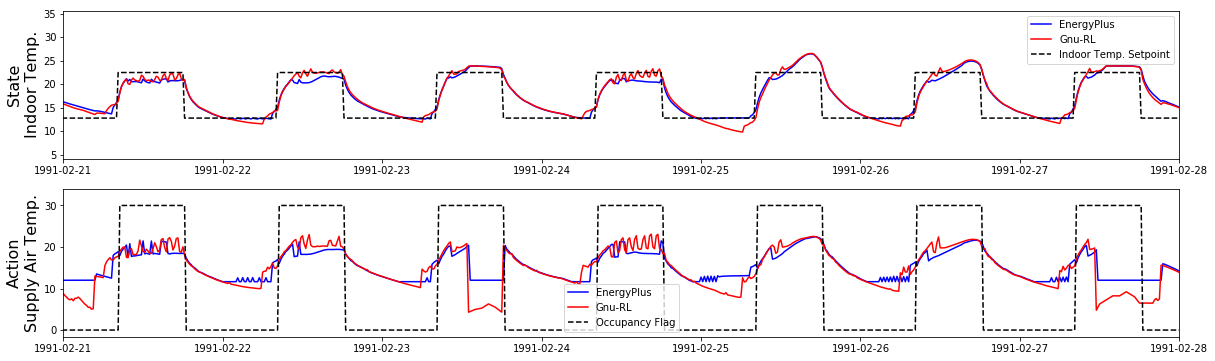

In [17]:
start_time = pd.datetime(year = 1991, month = 2, day = 21)
end_time = start_time + pd.Timedelta(days = 7)
plotPerf(rl, baseline, start_time, end_time)

# Reward

In [21]:
def CalReward(df, eta):
    df["eta"] = pd.Series([eta[int(occupied)] for occupied in df["Occupancy Flag"]], index = df.index)
    df["Reward"] = - 0.5 * df["eta"] * (df["Indoor Temp."] - df["Indoor Temp. Setpoint"])**2 - df["Delta T"]
    return df

eta = [0.1, 4]

rl = CalReward(rl, eta)

baseline["Delta T"] = baseline["Sys Out Temp."] - baseline["MA Temp."]
baseline = CalReward(baseline, eta)

In [22]:
ResReward = pd.DataFrame(rl["Reward"]-baseline["Reward"])

ResReward["Day"] = pd.Series([time.day for time in ResReward.index], index = ResReward.index)
ResReward["Month"] = pd.Series([time.month for time in ResReward.index], index = ResReward.index)
mean = ResReward.groupby(["Month", "Day"]).mean()
std = ResReward.groupby(["Month", "Day"]).std()

index = pd.date_range(start='1/1/2017', end='3/31/2017')
RewardStats = pd.DataFrame(np.concatenate([mean.values[:90], std.values[:90]], axis =1), index = index, columns = ["Mean", "Std"])

Text(0,0.5,'Residue Reward')

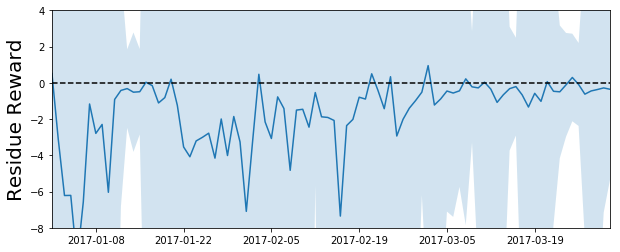

In [23]:
fig = plt.figure(figsize=(10, 4))

start_time = pd.datetime(year = 2017, month = 1, day = 1)
end_time =pd.datetime(year = 2017, month = 3, day = 31)

plt.plot(RewardStats["Mean"])
plt.fill_between(RewardStats.index, RewardStats["Mean"]-1.645*RewardStats["Std"], RewardStats["Mean"]+1.645*RewardStats["Std"], alpha = 0.2)

plt.plot((start_time, end_time), (0, 0), 'k--')

plt.xlim((start_time, end_time))
plt.ylim((-8, 4))

plt.ylabel("Residue Reward", fontsize = 20)